# Part 1: Move-responsive aDBS parameter optimization

The following notebook selects an optimal configuration of settings for classifying movement state with the Medtronic RC+S.

The notebook also contains the analyses performed in the first half (optimization half) of the paper Dixon et al., 2025: "Movement-responsive deep brain stimulation for Parkinson’s Disease using a remotely optimized neural decoder." This includes figures 2-4 and the accompanying analyses, which are labeled in the markdown.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

from ipywidgets import *
from IPython.display import clear_output, display
from tkinter import Tk, filedialog

from rcssim import rcs_sim as rcs
from move_adbs_utils import *
from utils import *
from plotting_utils import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

%matplotlib widget

## Selecting candidate Power Bands

### Import curated training data (full day)

In [2]:
# Select a folder containing the curated training data
choose_folder_button = widgets.Button(description='Choose "optimization_data" folder')
display(choose_folder_button)

output = widgets.Output()

@output.capture(clear_output=False, wait=True)
def choose_folder(b):
    clear_output()
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    b.folder = filedialog.askdirectory()
    global my_folder
    my_folder = b.folder
    print(b.folder)

choose_folder_button.on_click(choose_folder)
display(output)

t = type('test', (object,), {})()
choose_folder(t)

Button(description='Choose "optimization_data" folder', style=ButtonStyle())

Output()

In [3]:
# Load the data
amp_gains_left = np.genfromtxt(my_folder 
                               + '/202206_move_responsive_training_data' 
                               + '/amp_gains_left.csv', 
                               delimiter=',').astype(int)
amp_gains_right = np.genfromtxt(my_folder 
                                + '/202206_move_responsive_training_data'
                                + '/amp_gains_right.csv', 
                                delimiter=',').astype(int)
TD_df_left = pd.read_csv(my_folder 
                         + '/202206_move_responsive_training_data'
                         + '/TD_left_full_D.csv')
TD_df_right = pd.read_csv(my_folder 
                          + '/202206_move_responsive_training_data'
                          + '/TD_right_full_D.csv')

### Compute "Personalized" Power Bands

In [4]:
fs_td = 500
L = 256    
interval = 200
hann_win = rcs.create_hann_window(L, percent=100)
spec_left = [0, 0, 0]
spec_right = [0, 0, 0]

center_freqs = np.arange(L/2) * fs_td/L
f_mask = (center_freqs > 0) & (center_freqs < 100)
pca_mdl_left = [0, 0, 0]
pca_mdl_right = [0, 0, 0]

f_idx = np.where(f_mask)[0]
power_bands_freq_left = [0, 0, 0]
power_bands_freq_right = [0, 0, 0]

for ch in range(3):
    spec_left[ch], _ = compute_specgram(TD_df_left, ch, fs_td, L, interval, 
                                        hann_win, amp_gains_left)
    spec_right[ch], _ = compute_specgram(TD_df_right, ch, fs_td, L, interval, 
                                         hann_win, amp_gains_right)
    spec_left[ch] = spec_left[ch].T
    spec_right[ch] = spec_right[ch].T
    
    pca_mdl_left[ch], pca_mdl_right[ch] = compute_pca(
                                                    spec_left[ch][f_mask,100:], 
                                                    spec_right[ch][f_mask,100:], 
                                                    log_scale=False,
                                                    z_score=True)
    
    _, power_bands_freq_left[ch] = convert_pc_to_pb(
                                                pca_mdl_left[ch].components_, 
                                                center_freqs[f_mask], num_pcs=4, 
                                                included_idx=f_idx)
    _, power_bands_freq_right[ch] = convert_pc_to_pb(
                                                pca_mdl_right[ch].components_, 
                                                center_freqs[f_mask], num_pcs=4, 
                                                included_idx=f_idx)

In [5]:
# Canonical Power Bands
canonical_pbs = [[0,[4,7]],
                 [0,[8,12]],
                 [0,[13,30]],
                 [0,[60,90]],
                 [1,[4,7]],
                 [1,[8,12]],
                 [1,[13,30]],
                 [1,[60,90]],
                 [2,[4,7]],
                 [2,[8,12]],
                 [2,[13,30]],
                 [2,[60,90]]]

# "Principal" Power Bands
principal_pbs_left = []
for ch in range(3):
    for pb in range(4):
        pb_edges = [np.floor(power_bands_freq_left[ch][pb,0]+0.5).astype(int),
                    np.floor(power_bands_freq_left[ch][pb,1]+0.5).astype(int)]
        principal_pbs_left += [[ch, pb_edges]]
# principal_pbs_left = [[0, [76, 100]],
#                       [0, [6, 18]],
#                       [0, [18, 25]],
#                       [0, [47, 63]],
#                       [1, [12, 27]],
#                       [1, [72, 100]],
#                       [1, [6, 12]],
#                       [1, [31, 39]],
#                       [2, [12, 27]],
#                       [2, [72, 100]],
#                       [2, [6, 12]],
#                       [2, [63, 70]]]


principal_pbs_right = []
for ch in range(3):
    for pb in range(4):
        pb_edges = [np.floor(power_bands_freq_right[ch][pb,0]+0.5).astype(int),
                    np.floor(power_bands_freq_right[ch][pb,1]+0.5).astype(int)]
        principal_pbs_right += [[ch, pb_edges]]
# principal_pbs_right = [[0, [72, 100]],
#                        [0, [6, 27]],
#                        [0, [27, 47]],
#                        [0, [53, 59]],
#                        [1, [10, 29]],
#                        [1, [57, 100]],
#                        [1, [6, 10]],
#                        [1, [47, 57]],
#                        [2, [10, 25]],
#                        [2, [80, 100]],
#                        [2, [6, 10]],
#                        [2, [63, 70]]]

#### Figure 3c: Personalized power band frequency weightings

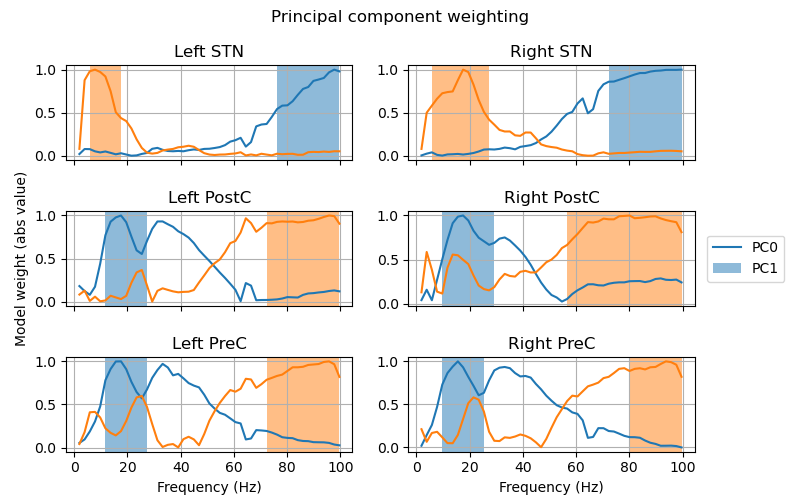

In [6]:
plt.style.use('default')
fig, ax = plt.subplots(3, 2, figsize=(8, 5), sharex=True, sharey=False)

for ch in range(3):  
    _, _, = plot_pca_pb(pca_mdl_left[ch], pca_mdl_right[ch],
                        power_bands_freq_left[ch], power_bands_freq_right[ch],
                        center_freqs[f_mask], num_pcs=2, fig=fig, ax=ax[ch,:],
                        abs_val=True, norm_weights='max')
    
    if ch < 2:
        ax[ch,0].tick_params(labelbottom=False)
        ax[ch,1].tick_params(labelbottom=False)
        ax[ch,0].set(xlabel=None)
        ax[ch,1].set(xlabel=None)
    if ch != 1:
        ax[ch,1].get_legend().set_visible(False)
        ax[ch,0].set(ylabel=None)
        

ax[0,0].set_title('Left STN')
ax[0,1].set_title('Right STN')
ax[1,0].set_title('Left PostC')
ax[1,1].set_title('Right PostC')
ax[2,0].set_title('Left PreC')
ax[2,1].set_title('Right PreC')

plt.tight_layout()
# plt.savefig('pca.svg', format='svg')

#### Figure 3d: Comparison of Personalized and Canonical power band frequency edges

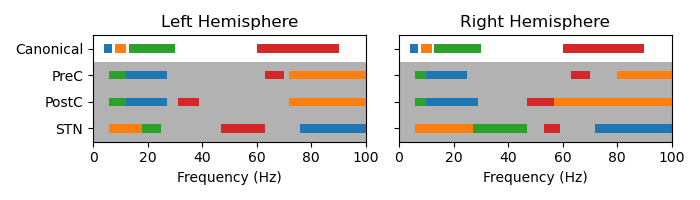

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(7, 2), sharex=True, sharey=True)
clr = ['#1f77b4', '#ff7f0e', '#2ca02c', 'tab:red']

ax[0].axhspan(0, 0.75, facecolor='tab:gray', alpha=0.6)
ax[1].axhspan(0, 0.75, facecolor='tab:gray', alpha=0.6)

tick_loc = [0.125, 0.375, 0.625, 0.875]
for ch in range(3):
    for pb in range(4):
        ax[0].axvspan(principal_pbs_left[ch*4+pb][1][0], 
                        principal_pbs_left[ch*4+pb][1][1],
                        tick_loc[ch]-0.04, tick_loc[ch]+0.04, facecolor=clr[pb])
        ax[1].axvspan(principal_pbs_right[ch*4+pb][1][0], 
                        principal_pbs_right[ch*4+pb][1][1],
                        tick_loc[ch]-0.04, tick_loc[ch]+0.04, facecolor=clr[pb])

for pb in range(4):
    ax[0].axvspan(canonical_pbs[pb][1][0], 
                  canonical_pbs[pb][1][1],
                  tick_loc[3]-0.04, tick_loc[3]+0.04, facecolor=clr[pb])
    ax[1].axvspan(canonical_pbs[pb][1][0], 
                  canonical_pbs[pb][1][1],
                  tick_loc[3]-0.04, tick_loc[3]+0.04, facecolor=clr[pb])

ax[0].set_title('Left Hemisphere')
ax[1].set_title('Right Hemisphere')
ax[0].set_xlim([0,100])
ax[0].set_ylim([0,1])
ax[0].set_xlabel('Frequency (Hz)')
ax[1].set_xlabel('Frequency (Hz)')
ax[0].set_yticks(tick_loc)
ax[0].set_yticklabels(['STN', 'PostC', 'PreC', 'Canonical'])

plt.tight_layout()
# plt.savefig('PB_ranges.svg', format='svg')

### Plot the correlation matrices for all Power Bands

In [8]:
# Convert mV to internal RC+S units
TD_left = TD_df_left.to_numpy()[:,1:]
time_td_left = TD_df_left.timestamp.values
TD_right = TD_df_right.to_numpy()[:,1:]
time_td_right = TD_df_right.timestamp.values
for ch in range(3):
    TD_left[:,ch] = rcs.transform_mv_to_rcs(TD_left[:,ch], 
                                            amp_gains_left[ch])
    TD_right[:,ch] = rcs.transform_mv_to_rcs(TD_right[:,ch], 
                                             amp_gains_right[ch])

# Separate PB's for each channel to run extraction faster
pbs_left = [0,0,0]
pbs_left[0] = np.array([canonical_pbs[i][1] for i in [0,1,2,3]] 
                       + [principal_pbs_left[i][1] for i in [0,1,2,3]])
pbs_left[1] = np.array([canonical_pbs[i][1] for i in [4,5,6,7]] 
                       + [principal_pbs_left[i][1] for i in [4,5,6,7]])
pbs_left[2] = np.array([canonical_pbs[i][1] for i in [8,9,10,11]] 
                       + [principal_pbs_left[i][1] for i in [8,9,10,11]])
pbs_right = [0,0,0]
pbs_right[0] = np.array([canonical_pbs[i][1] for i in [0,1,2,3]] 
                        + [principal_pbs_right[i][1] for i in [0,1,2,3]])
pbs_right[1] = np.array([canonical_pbs[i][1] for i in [4,5,6,7]] 
                        + [principal_pbs_right[i][1] for i in [4,5,6,7]])
pbs_right[2] = np.array([canonical_pbs[i][1] for i in [8,9,10,11]] 
                        + [principal_pbs_right[i][1] for i in [8,9,10,11]])

can_idx = np.concatenate([np.arange(4), np.arange(4)+8, np.arange(4)+16])
pca_idx_left = np.concatenate([np.array([1,2,3,0])+4, 
                               np.array([2,0,3,1])+12, 
                               np.array([2,0,3,1])+20])
pca_idx_right = np.concatenate([np.array([1,2,3,0])+4, 
                                np.array([2,0,3,1])+12, 
                                np.array([2,0,3,1])+20])
    
# Compute power band signals
fs_td = 500
L = 1024
interval = 50
bit_shift = 3
hann_win = rcs.create_hann_window(L, percent=100)

for ch in range(3):
    fft_left, time_fft_left = rcs.td_to_fft(TD_left[:,ch], time_td_left, 
                                            fs_td, L, interval, hann_win)
    pb_leftX = rcs.fft_to_pb(fft_left, fs_td, L, bit_shift, 
                             band_edges_hz=pbs_left[ch])

    fft_right, time_fft_right = rcs.td_to_fft(TD_right[:,ch], time_td_right, 
                                              fs_td, L, interval, hann_win)
    pb_rightX = rcs.fft_to_pb(fft_right, fs_td, L, bit_shift, 
                              band_edges_hz=pbs_right[ch])
    
    if ch == 0:
        pb_left = pb_leftX
        pb_right = pb_rightX
    else:
        pb_left = np.append(pb_left, pb_leftX, axis=1)
        pb_right = np.append(pb_right, pb_rightX, axis=1)

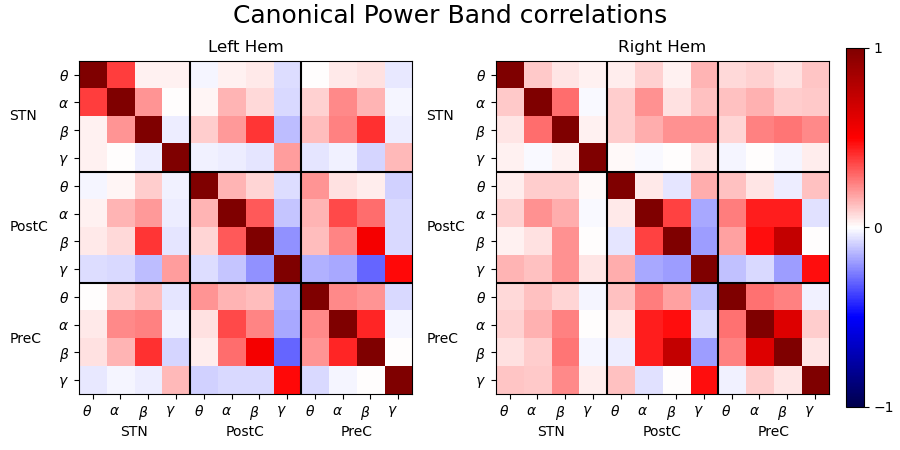

In [9]:
corr_mat_left = np.corrcoef(pb_left[:,can_idx].T)
corr_mat_right = np.corrcoef(pb_right[:,can_idx].T)

fig, ax = plt.subplots(1, 2, figsize=(9, 4.5), constrained_layout=True)
fig.suptitle('Canonical Power Band correlations', fontsize=18)

cax0 = ax[0].matshow(corr_mat_left, cmap='seismic', vmin=-1, vmax=1)
ax[0].set_title('Left Hem')
cax1 = ax[1].matshow(corr_mat_right, cmap='seismic', vmin=-1, vmax=1)
ax[1].set_title('Right Hem')

for i in range(2):
    ax[i].set_yticks(np.arange(12))
    ax[i].set_yticklabels([r'$\theta$',
                           r'$\alpha$',
                           r'$\beta$',
                           r'$\gamma$']*3)
    ax[i].set_xticks(np.arange(12))
    ax[i].set_xticklabels([r'$\theta$',
                           r'$\alpha$',
                           r'$\beta$',
                           r'$\gamma$']*3, ha='right')
    ax[i].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    ax[i].axvline(3.5, color='k')
    ax[i].axvline(7.5, color='k')
    ax[i].axhline(3.5, color='k')
    ax[i].axhline(7.5, color='k')
    ax[i].annotate('STN', [1.5, 13], ha='center', annotation_clip=False)
    ax[i].annotate('PostC', [5.5, 13], ha='center', annotation_clip=False)
    ax[i].annotate('PreC', [9.5, 13], ha='center', annotation_clip=False)
    ax[i].annotate('STN', [-3, 1.5,], va='center', annotation_clip=False)
    ax[i].annotate('PostC', [-3, 5.5], va='center', annotation_clip=False)
    ax[i].annotate('PreC', [-3, 9.5], va='center', annotation_clip=False)

cbar = fig.colorbar(cax1, ax=ax[1])
cbar.set_ticks([-1,0,1])


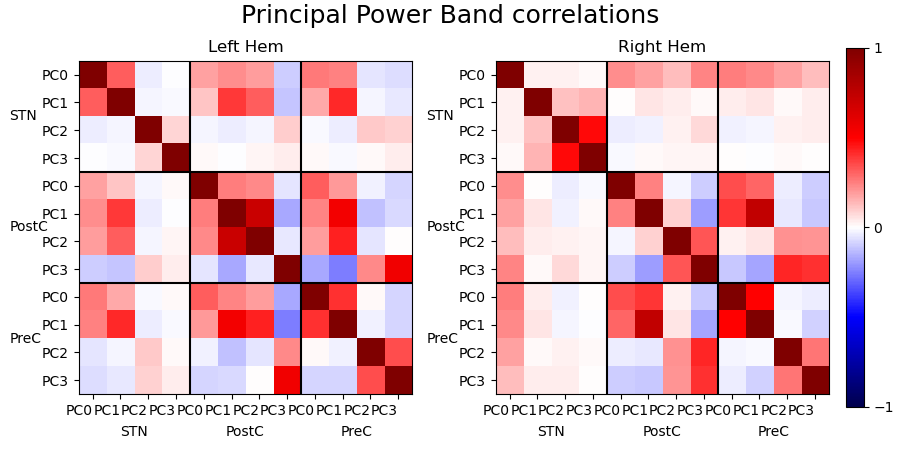

In [10]:
corr_mat_left = np.corrcoef(pb_left[:,pca_idx_left].T)
corr_mat_right = np.corrcoef(pb_right[:,pca_idx_right].T)

fig, ax = plt.subplots(1, 2, figsize=(9, 4.5), constrained_layout=True)
fig.suptitle('Principal Power Band correlations', fontsize=18)

cax0 = ax[0].matshow(corr_mat_left, cmap='seismic', vmin=-1, vmax=1)
ax[0].set_title('Left Hem')
cax1 = ax[1].matshow(corr_mat_right, cmap='seismic', vmin=-1, vmax=1)
ax[1].set_title('Right Hem')

for i in range(2):
    ax[i].set_yticks(np.arange(12))
    ax[i].set_yticklabels([r'PC0',
                           r'PC1',
                           r'PC2',
                           r'PC3']*3)
    ax[i].set_xticks(np.arange(12))
    ax[i].set_xticklabels([r'PC0',
                           r'PC1',
                           r'PC2',
                           r'PC3']*3, ha='right')
    ax[i].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    ax[i].axvline(3.5, color='k')
    ax[i].axvline(7.5, color='k')
    ax[i].axhline(3.5, color='k')
    ax[i].axhline(7.5, color='k')
    ax[i].annotate('STN', [1.5, 13], ha='center', annotation_clip=False)
    ax[i].annotate('PostC', [5.5, 13], ha='center', annotation_clip=False)
    ax[i].annotate('PreC', [9.5, 13], ha='center', annotation_clip=False)
    ax[i].annotate('STN', [-3, 1.5,], va='center', annotation_clip=False)
    ax[i].annotate('PostC', [-3, 5.5], va='center', annotation_clip=False)
    ax[i].annotate('PreC', [-3, 9.5], va='center', annotation_clip=False)

cbar = fig.colorbar(cax1, ax=ax[1])
cbar.set_ticks([-1,0,1])


In [11]:
# Clear large workspace variables
del TD_df_left, TD_left, time_td_left, pb_left
del TD_df_right, TD_right, time_td_right, pb_right

## Accelerometry preprocessing

### Import curated training data (multistim + Apple Watch)

In [12]:
### Load neural data
TD_df_left = pd.read_csv(my_folder + '/TD_df_left.csv', index_col=0)
TD_df_right = pd.read_csv(my_folder + '/TD_df_right.csv', index_col=0)

### Load movement data
watch_left = pd.read_csv(my_folder + '/watch_left.csv', index_col=0)
watch_right = pd.read_csv(my_folder + '/watch_right.csv', index_col=0)

### Define task segments to be used for testing
event_ts = pd.read_csv(my_folder 
                       + '/202206_move_responsive_training_data'
                       + '/test_day_event_ts.csv')
arm_segment_names = ['chest_tapping', 
                     'rest', 
                     'finger_tapping_right',
                     'finger_tapping_left',
                     'hand_open_close_right',
                     'hand_open_close_left',
                     'hand_rotations_right',
                     'hand_rotations_left']


### Plot distribution of transformed accelerometry

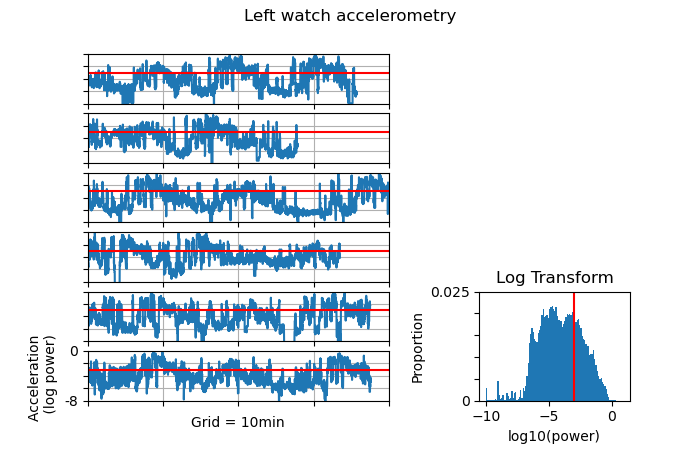

In [13]:
fig = plt.figure(figsize=(7, 4.5))
fig.suptitle('Left watch accelerometry')
gs = GridSpec(6,2, figure=fig, wspace=0.4, width_ratios=[2/3, 1/3])

ax = list()
for i in range(6):
    ax.append(fig.add_subplot(gs[i,0]))
    t0 = watch_left['timestamp'][watch_left['session_id']==i].values[0]
    ax[i].plot(watch_left['timestamp'][watch_left['session_id']==i]-t0,
               np.log10(watch_left['accel'][watch_left['session_id']==i]))
    ax[i].axhline(-3, color='r')
    ax[i].set_xlim([0,2400])
    ax[i].set_xticks(np.arange(0,2401,600))
    ax[i].set_xticklabels([])
    ax[i].set_ylim([-8, 0])
    ax[i].set_yticks(np.arange(-8, 1, 2))
    ax[i].set_yticklabels([])
    ax[i].grid()
ax[5].set_xlabel('Grid = 10min')
ax[5].set_yticklabels(['-8','','','','0'])
ax[5].set_ylabel('Acceleration \n (log power)')

log_hist = fig.add_subplot(gs[4:6,1])
log_hist.hist(np.log10(watch_left['accel']), bins=np.arange(-10,1,0.1),
             weights=np.ones(watch_left.shape[0])/watch_left.shape[0])
log_hist.axvline(-3, color='r')
log_hist.set_xlabel('log10(power)')
log_hist.set_ylim([0,0.025])
log_hist.set_yticks(np.arange(0,0.026,0.005))
log_hist.set_yticklabels(['0'] + ['']*4 + ['0.025'])
log_hist.set_ylabel('Proportion')
log_hist.set_title('Log Transform');

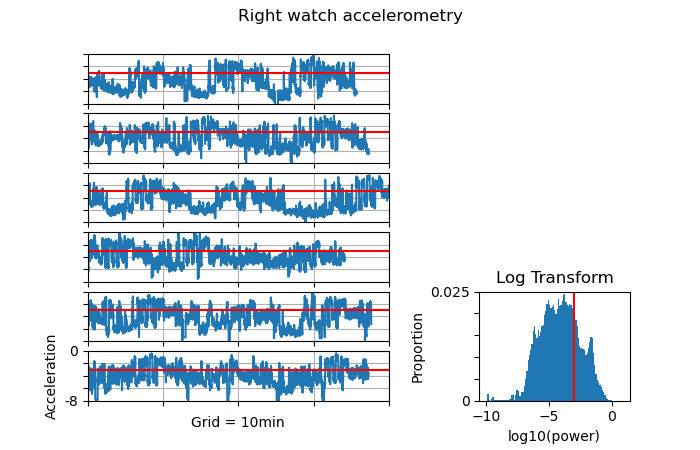

In [14]:
fig = plt.figure(figsize=(7, 4.5))
fig.suptitle('Right watch accelerometry')
gs = GridSpec(6,2, figure=fig, wspace=0.4, width_ratios=[2/3, 1/3])

ax = list()
for i in range(6):
    ax.append(fig.add_subplot(gs[i,0]))
    t0 = watch_right['timestamp'][watch_right['session_id']==i].values[0]
    ax[i].plot(watch_right['timestamp'][watch_right['session_id']==i]-t0,
               np.log10(watch_right['accel'][watch_right['session_id']==i]))
    ax[i].axhline(-3, color='r')
    ax[i].set_xlim([0,2400])
    ax[i].set_xticks(np.arange(0,2401,600))
    ax[i].set_xticklabels([])
    ax[i].set_ylim([-8, 0])
    ax[i].set_yticks(np.arange(-8, 1, 2))
    ax[i].set_yticklabels([])
    ax[i].grid()
ax[5].set_xlabel('Grid = 10min')
ax[5].set_yticklabels(['-8','','','','0'])
ax[5].set_ylabel('Acceleration')

log_hist = fig.add_subplot(gs[4:6,1])
log_hist.hist(np.log10(watch_right['accel']), bins=np.arange(-10,1,0.1),
             weights=np.ones(watch_right.shape[0])/watch_right.shape[0])
log_hist.axvline(-3, color='r')
log_hist.set_xlabel('log10(power)')
log_hist.set_ylim([0,0.025])
log_hist.set_yticks(np.arange(0,0.026,0.005))
log_hist.set_yticklabels(['0'] + ['']*4 + ['0.025'])
log_hist.set_ylabel('Proportion')
log_hist.set_title('Log Transform');

### Figure 2b: Plot select power bands with accelerometry

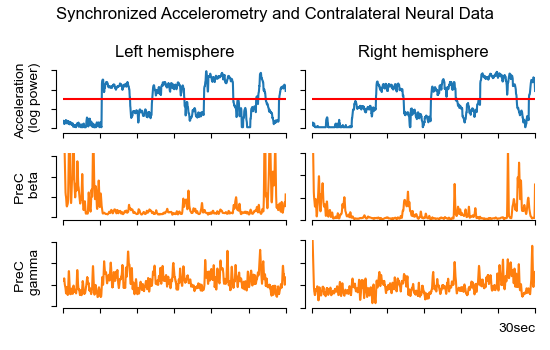

In [15]:
plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

fig, ax = plt.subplots(3, 2, figsize=(5.5, 3.5), sharex='all')
fig.suptitle('Synchronized Accelerometry and Contralateral Neural Data')

# specify session to plot
s = 3

# plot the accelerometry
t0 = TD_df_left['timestamp'][TD_df_left['session_id']==s].values[0]
ax[0,0].plot(watch_right['timestamp'][watch_right['session_id']==s]-t0,
             np.clip(
                 np.log10(watch_right['accel'][watch_right['session_id']==s]),
                 -5.9, 0),
             color='tab:blue')
ax[0,0].set_ylabel('Acceleration \n (log power)')
ax[0,0].set_title('Left hemisphere')
ax[0,0].axhline(-3, color='r')

ax[0,1].plot(watch_left['timestamp'][watch_left['session_id']==s]-t0,
             np.clip(
                 np.log10(watch_left['accel'][watch_left['session_id']==s]), 
                 -5.9, 0),
             color='tab:blue')
ax[0,1].set_title('Right hemisphere')
ax[0,1].axhline(-3, color='r')

ax[0,0].set_ylim([-6.5,0.5])
ax[0,0].set_yticks(np.arange(-6,1,2))
ax[0,1].set_ylim([-6.5,0.5])
ax[0,1].set_yticks(np.arange(-6,1,2))
for i in range(3):
    for j in range(2):
        ax[i,j].set_yticklabels([])
        
ax[0,0].spines.left.set_bounds(-6, 0)
ax[0,0].spines.left.set_position(('outward', 5))
ax[0,0].spines.right.set_visible(False)
ax[0,0].spines.top.set_visible(False)
ax[0,0].yaxis.set_ticks_position('left')
ax[0,0].xaxis.set_ticks_position('bottom')

ax[0,1].spines.left.set_bounds(-6, 0)
ax[0,1].spines.left.set_position(('outward', 5))
ax[0,1].spines.right.set_visible(False)
ax[0,1].spines.top.set_visible(False)
ax[0,1].yaxis.set_ticks_position('left')
ax[0,1].xaxis.set_ticks_position('bottom')
    
# plot the neural spectrograms
# Convert mV to internal RC+S units
TD_left = TD_df_left.to_numpy()[TD_df_left['session_id']==s,-3:].astype(
                                                                      'float64')
time_td_left = TD_df_left.timestamp.values[TD_df_left['session_id']==s]
TD_right = TD_df_right.to_numpy()[TD_df_right['session_id']==s,-3:].astype(
                                                                      'float64')
time_td_right = TD_df_right.timestamp.values[TD_df_right['session_id']==s]
for ch in range(3):
    TD_left[:,ch] = rcs.transform_mv_to_rcs(TD_left[:,ch], 
                                            amp_gains_left[ch])
    TD_right[:,ch] = rcs.transform_mv_to_rcs(TD_right[:,ch], 
                                             amp_gains_right[ch])
    
# Compute power band signals
fs_td = 500
L = 1024
interval = 100
bit_shift = 3
hann_win = rcs.create_hann_window(L, percent=100)

for ch in range(3):
    fft_left, time_fft_left = rcs.td_to_fft(TD_left[:,ch], time_td_left, 
                                            fs_td, L, interval, hann_win)
    pb_leftX = rcs.fft_to_pb(fft_left, fs_td, L, bit_shift, band_edges_hz=[])

    fft_right, time_fft_right = rcs.td_to_fft(TD_right[:,ch], time_td_right, 
                                              fs_td, L, interval, hann_win)
    pb_rightX = rcs.fft_to_pb(fft_right, fs_td, L, bit_shift, band_edges_hz=[])
    
    if ch == 0:
        pb_left = pb_leftX[:,:,np.newaxis]
        pb_right = pb_rightX[:,:,np.newaxis]
    else:
        pb_left = np.append(pb_left, pb_leftX[:,:,np.newaxis], axis=2)
        pb_right = np.append(pb_right, pb_rightX[:,:,np.newaxis], axis=2)
f = np.arange(L/2) * fs_td/L

# plot
ax[1,0].plot(time_fft_left-t0, np.sum(pb_left[:,27:61,2], axis=1), color='tab:orange')
ax[1,0].set_ylim([-1e3,18e3])
ax[1,0].set_yticks(np.linspace(0, 17e3, 4))
ax[1,0].set_ylabel('PreC \n beta')
ax[2,0].plot(time_fft_left-t0, np.sum(pb_left[:,124:185,2], axis=1), color='tab:orange')
ax[2,0].set_ylim([-10,410])
ax[2,0].set_yticks(np.linspace(0, 400, 4))
ax[2,0].set_ylabel('PreC \n gamma')

ax[1,1].plot(time_fft_right-t0, np.sum(pb_right[:,27:61,2], axis=1), color='tab:orange')
ax[1,1].set_ylim([0,2.4e4])
ax[1,1].set_yticks(np.linspace(0, 2.4e4, 4))
ax[2,1].plot(time_fft_right-t0, np.sum(pb_right[:,124:185,2], axis=1), color='tab:orange')
ax[2,1].set_ylim([0,400])
ax[2,1].set_yticks(np.linspace(0, 400, 4))


ax[1,0].spines.left.set_bounds(0, 17e3)
ax[1,0].spines.left.set_position(('outward', 5))
ax[1,0].spines.right.set_visible(False)
ax[1,0].spines.top.set_visible(False)
ax[1,0].yaxis.set_ticks_position('left')
ax[1,0].xaxis.set_ticks_position('bottom')

ax[2,0].spines.left.set_bounds(0, 400)
ax[2,0].spines.left.set_position(('outward', 5))
ax[2,0].spines.right.set_visible(False)
ax[2,0].spines.top.set_visible(False)
ax[2,0].yaxis.set_ticks_position('left')
ax[2,0].xaxis.set_ticks_position('bottom')

ax[1,1].spines.left.set_bounds(0, 2.4e4)
ax[1,1].spines.left.set_position(('outward', 5))
ax[1,1].spines.right.set_visible(False)
ax[1,1].spines.top.set_visible(False)
ax[1,1].yaxis.set_ticks_position('left')
ax[1,1].xaxis.set_ticks_position('bottom')

ax[2,1].spines.left.set_bounds(0, 400)
ax[2,1].spines.left.set_position(('outward', 5))
ax[2,1].spines.right.set_visible(False)
ax[2,1].spines.top.set_visible(False)
ax[2,1].yaxis.set_ticks_position('left')
ax[2,1].xaxis.set_ticks_position('bottom')

ax[0,0].set_xlim([615,795])
ax[0,0].set_xticks(np.arange(615,796,30))
ax[2,0].set_xticklabels([])
ax[2,1].set_xlabel('30sec');

plt.tight_layout()
ax[2,1].xaxis.set_label_coords(0.92, -0.22)
# plt.savefig('training_data_example.svg', format='svg')

## Hyperparameter optimization and final model evaluation

### Run optimization or load previous results

In [16]:
# Organize right hem, left hand training data
right_td = []
for i in range(6):
    td_tmp = TD_df_right.to_numpy()[TD_df_right['session_id']==i,-3:].astype(
                                                                      'float64')
    for ch in range(3):
        td_tmp[:,ch] = rcs.transform_mv_to_rcs(td_tmp[:,ch], 
                                               amp_gains_right[ch])
    right_td.append(td_tmp)

right_td_ts = [TD_df_right.to_numpy()[TD_df_right['session_id']==i,0].astype(
                                                                      'float64') 
               for i in range(6)]
left_accel = [np.log10(watch_left.to_numpy()[watch_left['session_id']==i,2]) 
              for i in range(6)]
left_accel_ts = [watch_left.to_numpy()[watch_left['session_id']==i,0] 
                 for i in range(6)]

# Organize left hem, right hand training data
left_td = []
for i in range(6):
    td_tmp = TD_df_left.to_numpy()[TD_df_left['session_id']==i,-3:].astype(
                                                                      'float64')
    for ch in range(3):
        td_tmp[:,ch] = rcs.transform_mv_to_rcs(td_tmp[:,ch], 
                                               amp_gains_left[ch])
    left_td.append(td_tmp)

left_td_ts = [TD_df_left.to_numpy()[TD_df_left['session_id']==i,0].astype(
                                                                      'float64') 
              for i in range(6)]
right_accel = [np.log10(watch_right.to_numpy()[watch_right['session_id']==i,2]) 
               for i in range(6)]
right_accel_ts = [watch_right.to_numpy()[watch_right['session_id']==i,0] 
                  for i in range(6)]

In [17]:
run_opt_button = widgets.Button(description = 'Run optimization')
load_results_button = widgets.Button(description = 'Load prior results')

output = widgets.Output()
optButton = OptButton(output=output, 
                      my_folder=my_folder 
                                + '/202206_move_responsive_training_data', 
                      left_td=left_td, left_td_ts=left_td_ts, 
                      right_td=right_td, right_td_ts=right_td_ts, 
                      left_accel=left_accel, left_accel_ts=left_accel_ts, 
                      right_accel=right_accel, right_accel_ts=right_accel_ts,
                      canonical_pbs=canonical_pbs, 
                      principal_pbs_left=principal_pbs_left,
                      principal_pbs_right=principal_pbs_right)
 
load_results_button.on_click(optButton.load_opt_results)
run_opt_button.on_click(optButton.run_optimization)

display(widgets.HBox([run_opt_button, load_results_button]))

optButton.load_opt_results(_)

output

Output()

### Biomarker analysis (Shallow Optimization)

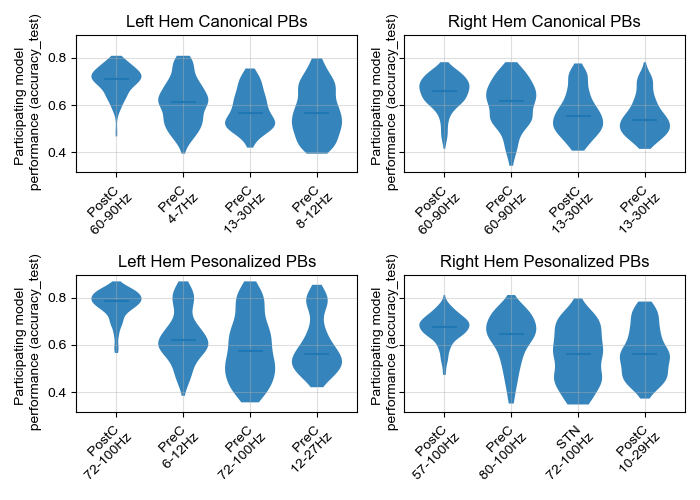

In [18]:
fig, ax = plt.subplots(2,2, figsize=(7,5), sharex=False, sharey=True)

plot_participating_performance(optButton.left_hem_can_results, canonical_pbs, 
                               ax[0,0], metric='accuracy_test', num_pbs=4,
                               use_median=True)
ax[0,0].set_title('Left Hem Canonical PBs')
plot_participating_performance(optButton.right_hem_can_results, canonical_pbs, 
                               ax[0,1], metric='accuracy_test', num_pbs=4,
                               use_median=True)
ax[0,1].set_title('Right Hem Canonical PBs')

plot_participating_performance(optButton.left_hem_pca_results, 
                               principal_pbs_left, ax[1,0], 
                               metric='accuracy_test', num_pbs=4,
                               use_median=True)
ax[1,0].set_title('Left Hem Pesonalized PBs')
plot_participating_performance(optButton.right_hem_pca_results, 
                               principal_pbs_right, ax[1,1], 
                               metric='accuracy_test', num_pbs=4,
                               use_median=True)
ax[1,1].set_title('Right Hem Pesonalized PBs');

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlim([-0.6, 3.6])

plt.tight_layout()

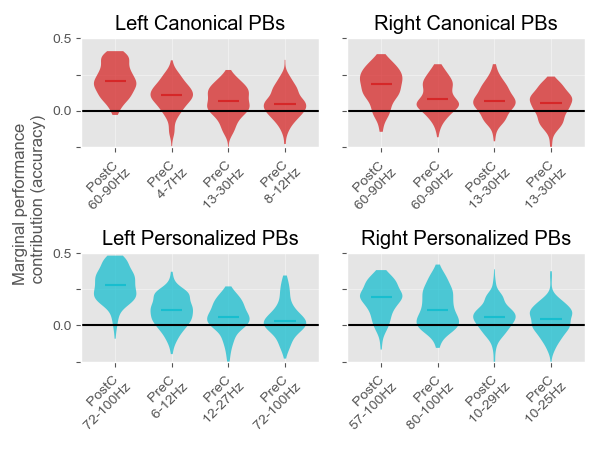

In [19]:
plt.style.use('ggplot')

fig, ax = plt.subplots(2,2, figsize=(6,4.5), sharex=False, sharey=True)

left_can_marginal_perf, left_can_top_pbs = \
    plot_marginal_performance(optButton.left_hem_can_results, canonical_pbs, 
                              ax[0,0], metric='accuracy_test', num_pbs=4,
                              use_median=True, color='tab:red')
ax[0,0].set_title('Left Canonical PBs')
ax[0,0].set_ylabel('Marginal performance \n contribution (accuracy)')
ax[0,0].set_ylim([-0.25, 0.5])
ax[0,0].set_yticks(np.arange(-0.25, 0.51, 0.25))
ax[0,0].set_yticklabels(['', '0.0', '', '0.5'])
ax[0,0].yaxis.set_label_coords(-0.15, -0.5)
right_can_marginal_perf, right_can_top_pbs = \
    plot_marginal_performance(optButton.right_hem_can_results, canonical_pbs, 
                              ax[0,1], metric='accuracy_test', num_pbs=4,
                              use_median=True, color='tab:red')
ax[0,1].set_title('Right Canonical PBs')
ax[0,1].set_ylabel('')

left_pca_marginal_perf, left_pca_top_pbs = \
    plot_marginal_performance(optButton.left_hem_pca_results, 
                              principal_pbs_left, ax[1,0], 
                              metric='accuracy_test', num_pbs=4,
                              use_median=True, color='tab:cyan')
ax[1,0].set_title('Left Personalized PBs')
ax[1,0].set_ylabel('')
right_pca_marginal_perf, right_pca_top_pbs = \
    plot_marginal_performance(optButton.right_hem_pca_results, 
                              principal_pbs_right, ax[1,1], 
                              metric='accuracy_test', num_pbs=4,
                              use_median=True, color='tab:cyan')
ax[1,1].set_title('Right Personalized PBs')
ax[1,1].set_ylabel('');

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlim([-0.6, 3.6])

plt.tight_layout()
# plt.savefig('biomarker_analysis.svg', format='svg')

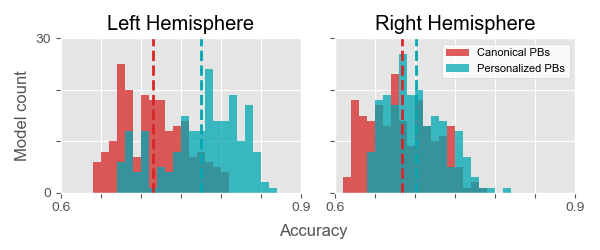

In [20]:
plt.style.use('ggplot')
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Select the top 100 models from each set
left_can_accuracy = np.sort(optButton.left_hem_can_results.accuracy_test.values)
left_can_accuracy = left_can_accuracy[-200:]
left_pca_accuracy = np.sort(optButton.left_hem_pca_results.accuracy_test.values)
left_pca_accuracy = left_pca_accuracy[-200:]

right_can_accuracy = np.sort(
                           optButton.right_hem_can_results.accuracy_test.values)
right_can_accuracy = right_can_accuracy[-200:]
right_pca_accuracy = np.sort(
                           optButton.right_hem_pca_results.accuracy_test.values)
right_pca_accuracy = right_pca_accuracy[-200:]

# Plot
fig, ax = plt.subplots(1,2, figsize=(6,2.5), sharex=True, sharey=True)

ax[0].set_title('Left Hemisphere')
ax[0].hist(left_can_accuracy, bins=np.arange(0.5,1.01,0.01), alpha=0.75, facecolor='tab:red')
ax[0].axvline(np.mean(left_can_accuracy), linestyle='--', color='tab:red',
              linewidth=2)
ax[0].hist(left_pca_accuracy, bins=np.arange(0.5,1.01,0.01), alpha=0.75, facecolor=[0, 0.66, 0.7])
ax[0].axvline(np.mean(left_pca_accuracy), linestyle='--', color=[0, 0.66, 0.7],
              linewidth=2)

ax[1].set_title('Right Hemisphere')
ax[1].hist(right_can_accuracy, bins=np.arange(0.5,1.01,0.01), alpha=0.75, 
           label='Canonical PBs', facecolor='tab:red')
ax[1].axvline(np.mean(right_can_accuracy), linestyle='--', color='tab:red',
              linewidth=2)
ax[1].hist(right_pca_accuracy, bins=np.arange(0.5,1.01,0.01), alpha=0.75, 
           label='Personalized PBs', facecolor=[0, 0.66, 0.7])
ax[1].axvline(np.mean(right_pca_accuracy), linestyle='--', color=[0, 0.66, 0.7],
             linewidth=2)

ax[0].set_xlabel('Accuracy')
ax[0].set_xticks(np.arange(0.6, 0.91, 0.05))
ax[0].set_xticklabels([0.6] + ['']*5 + [0.9])
ax[0].set_xlim([0.6, 0.9])
ax[0].set_ylim([0,30])
ax[0].set_yticks(np.arange(0, 31, 10))
ax[0].set_yticklabels([0, '', '', 30])
ax[0].set_ylabel('Model count')
ax[1].legend(prop={'size': 8}, facecolor='w')

plt.tight_layout()
ax[0].xaxis.set_label_coords(1.05, -0.2)
# plt.savefig('PB_method_comparison.svg', format='svg')

In [21]:
# Compute permutation test results and participating PB's
_, p_left = ttest_ind(left_can_accuracy, left_pca_accuracy, 
                      permutations=10000)
_, p_right = ttest_ind(right_can_accuracy, right_pca_accuracy, 
                       permutations=10000)

top_proportions_left, top_pbs_left = find_participating_proportion(
    optButton.left_hem_pca_results, principal_pbs_left, num_pbs=4)
top_proportions_right, top_pbs_right = find_participating_proportion(
    optButton.right_hem_pca_results, principal_pbs_right, num_pbs=4)



print('LEFT HEMISPHERE')
print('Mean Canonical PB accuracy: ' + str(np.mean(left_can_accuracy)))
print('Mean Personalized PB accuracy: ' + str(np.mean(left_pca_accuracy)))
print('Difference: ' + str(np.mean(left_pca_accuracy) 
                           - np.mean(left_can_accuracy)))
print('Permutation test p-value: ' + str(p_left))
print('Proportion of top models with each PB:')
for i in range(4):
    print('\t' + str(top_pbs_left[i]) + ': ' + str(top_proportions_left[i]))

print('')

print('RIGHT HEMISPHERE')
print('Mean Canonical PB accuracy: ' + str(np.mean(right_can_accuracy)))
print('Mean Personalized PB accuracy: ' + str(np.mean(right_pca_accuracy)))
print('Difference: ' + str(np.mean(right_pca_accuracy) 
                           - np.mean(right_can_accuracy)))
print('Permutation test p-value: ' + str(p_right))
print('Proportion of top models with each PB:')
for i in range(4):
    print('\t' + str(top_pbs_right[i]) + ': ' + str(top_proportions_right[i]))

LEFT HEMISPHERE
Mean Canonical PB accuracy: 0.7152068440235411
Mean Personalized PB accuracy: 0.775049966541295
Difference: 0.05984312251775392
Permutation test p-value: 9.999000099990002e-05
Proportion of top models with each PB:
	[1, [72, 100]]: 0.905
	[2, [6, 12]]: 0.305
	[2, [72, 100]]: 0.28
	[0, [47, 63]]: 0.27

RIGHT HEMISPHERE
Mean Canonical PB accuracy: 0.6832599221789883
Mean Personalized PB accuracy: 0.7010821600682619
Difference: 0.017822237889273507
Permutation test p-value: 9.999000099990002e-05
Proportion of top models with each PB:
	[1, [57, 100]]: 0.68
	[2, [80, 100]]: 0.475
	[2, [63, 70]]: 0.28
	[2, [6, 10]]: 0.265


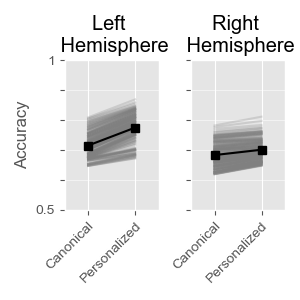

In [22]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(3,3), sharex=True, sharey=True)

ax[0].set_title('Left \n Hemisphere')
ax[0].plot(np.row_stack([left_can_accuracy, left_pca_accuracy]), 
           color='grey', alpha=0.25)
ax[0].plot([np.mean(left_can_accuracy), np.mean(left_pca_accuracy)],
           color='black', marker='s')
ax[0].grid(axis='y', alpha=0.5)

ax[1].set_title('Right \n Hemisphere')
ax[1].plot(np.row_stack([right_can_accuracy, right_pca_accuracy]), 
           color='grey', alpha=0.25)
ax[1].plot([np.mean(right_can_accuracy), np.mean(right_pca_accuracy)],
           color='black', marker='s')
ax[1].grid(axis='y', alpha=0.5)

ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['Canonical', 'Personalized'], 
                       rotation=45, ha='right', rotation_mode='anchor')
ax[1].set_xticklabels(['Canonical', 'Personalized'], 
                       rotation=45, ha='right', rotation_mode='anchor')
ax[0].set_xlim([-0.5,1.5])
ax[0].set_yticks(np.arange(0.5, 1.01, 0.1))
ax[0].set_yticklabels(['0.5']+['']*4+['1'])
ax[0].set_ylim([0.5,1])

ax[0].set_ylabel('Accuracy')
plt.tight_layout()

### Evaluate final model (Deep Optimization)

In [23]:
# set training data RIGHT HEM
print('RIGHT HEMISPHERE')

td = []
for i in range(5):
    td_tmp = TD_df_right.to_numpy()[TD_df_right['session_id']==i,-3:].astype(
                                                                      'float64')
    for ch in range(3):
        td_tmp[:,ch] = rcs.transform_mv_to_rcs(td_tmp[:,ch], 
                                               amp_gains_right[ch])
    td.append(td_tmp)
td_ts = [TD_df_right.to_numpy()[TD_df_right['session_id']==i,0].astype('float64') 
         for i in range(5)]

accel = [np.log10(watch_left.to_numpy()[watch_left['session_id']==i,2]) 
         for i in range(5)]
accel_ts = [watch_left.to_numpy()[watch_left['session_id']==i,0] 
            for i in range(5)]


# fit model and compute cross-validated accuracy on hyperparameter tuning data
right_mdl = RcsOptimizer()
right_mdl.set_data(td, td_ts, accel, accel_ts)
pb_info = [[1,[10,29]],
           [1,[57,100]], 
           [2,[80,100]]]
right_mdl.set_params(pb_info=pb_info, fft_size=256, interval=50,
               update_rate=8,
               lag=-0.3, 
               threshold=0.9764343875489059+0.2801787080866027,
               onset=3,
               termination=3)
acc, F1, conf_mat = right_mdl.cross_val()


# set testing data
right_mdl.fit_reg() #using first 5 days
test_day = TD_df_right[TD_df_right['session_id']==5]
td = [test_day.to_numpy()[:,-3:].astype('float64')]
for ch in range(3):
    td[0][:,ch] = rcs.transform_mv_to_rcs(td[0][:,ch], 
                                          amp_gains_right[ch])
td_ts = [test_day.timestamp.values] 
accel = [np.log10(watch_left.accel.values[watch_left['session_id']==5])]
accel_ts = [watch_left.timestamp.values[watch_left['session_id']==5]]

# final evaluation
right_mdl._output_mean = np.dot(right_mdl.weights, right_mdl.pb_scaler.mean_)
right_mdl.set_data(td, td_ts, accel, accel_ts)
right_state_true, right_state_pred, right_state_ts, \
    right_output, right_output_ts = right_mdl.predict(clock=50)
right_mask = find_segments(right_state_ts, event_ts, arm_segment_names)
conf_mat_right = compute_conf_mat(right_state_true[right_mask], 
                                  right_state_pred[right_mask])

acc = (conf_mat_right['TP'] + conf_mat_right['TN']) / \
      np.sum(list(conf_mat_right.values()))
precision = conf_mat_right['TP'] / (conf_mat_right['TP'] + conf_mat_right['FP'])
recall = conf_mat_right['TP'] / (conf_mat_right['TP'] + conf_mat_right['FN'])
F1 = 2*precision*recall / (precision + recall)
print('Held out test set accuracy: ' + str(np.round(acc*100, 2)) + '%')
print('Held out test set F1: ' + str(np.round(F1*100, 2)) + '%')
print(conf_mat_right)

# Turn conf_mat into an actual matrix for plotting heatmap
conf_mat_right = \
    np.array([[conf_mat_right['TN'], conf_mat_right['FP']],
              [conf_mat_right['FN'], conf_mat_right['TP']]])
conf_mat_right = np.around(conf_mat_right /
                           np.tile(np.sum(conf_mat_right, 1, keepdims=True), 2), 
                           decimals=2)

RIGHT HEMISPHERE
Held out test set accuracy: 76.39%
Held out test set F1: 73.39%
{'TP': 8371, 'FP': 5405, 'TN': 11260, 'FN': 664}


In [24]:
# set training data LEFT HEM
print('LEFT HEMISPHERE')

td = []
for i in range(5):
    td_tmp = TD_df_left.to_numpy()[TD_df_left['session_id']==i,-3:].astype(
                                                                      'float64')
    for ch in range(3):
        td_tmp[:,ch] = rcs.transform_mv_to_rcs(td_tmp[:,ch], 
                                               amp_gains_left[ch])
    td.append(td_tmp)

td_ts = [TD_df_left.to_numpy()[TD_df_left['session_id']==i,0].astype('float64') 
         for i in range(5)]
accel = [np.log10(watch_right.to_numpy()[watch_right['session_id']==i,2]) 
         for i in range(5)]
accel_ts = [watch_right.to_numpy()[watch_right['session_id']==i,0] 
            for i in range(5)]


# fit model and compute cross-validated accuracy on hyperparameter tuning data
left_mdl = RcsOptimizer()
left_mdl.set_data(td, td_ts, accel, accel_ts)
pb_info = [[1,[72, 100]],
           [1,[31, 39]],
           [2,[12, 27]],
           [2,[6,  12]]]
left_mdl.set_params(pb_info=pb_info, fft_size=256, interval=50,
                    update_rate=4,
                    lag=-0.2999166767017435, 
                    threshold=0.4838079459698036+0.27902730331534076,
                    onset=2,
                    termination=6)
acc, F1, conf_mat = left_mdl.cross_val()


# set testing data
left_mdl.fit_reg() #using first 5 days
test_day = TD_df_left[TD_df_left['session_id']==5]
td = [test_day.to_numpy()[:,-3:].astype('float64')]
for ch in range(3):
    td[0][:,ch] = rcs.transform_mv_to_rcs(td[0][:,ch], 
                                          amp_gains_left[ch])
td_ts = [test_day.timestamp.values] 
accel = [np.log10(watch_right.accel.values[watch_right['session_id']==5])]
accel_ts = [watch_right.timestamp.values[watch_right['session_id']==5]]

# final evaluation
left_mdl._output_mean = np.dot(left_mdl.weights, left_mdl.pb_scaler.mean_)
left_mdl.set_data(td, td_ts, accel, accel_ts)
left_state_true, left_state_pred, left_state_ts, \
    left_output, left_output_ts = left_mdl.predict(clock=50)
left_mask = find_segments(left_state_ts, event_ts, arm_segment_names)
conf_mat_left = compute_conf_mat(left_state_true[left_mask], 
                                 left_state_pred[left_mask])

acc = (conf_mat_left['TP'] + conf_mat_left['TN']) / \
      np.sum(list(conf_mat_left.values()))
precision = conf_mat_left['TP'] / (conf_mat_left['TP'] + conf_mat_left['FP'])
recall = conf_mat_left['TP'] / (conf_mat_left['TP'] + conf_mat_left['FN'])
F1 = 2*precision*recall / (precision + recall)
print('Held out test set accuracy: ' + str(np.round(acc*100, 2)) + '%')
print('Held out test set F1: ' + str(np.round(F1*100, 2)) + '%')
print(conf_mat_left)

# Turn conf_mat into an actual matrix for plotting heatmap
conf_mat_left = \
    np.array([[conf_mat_left['TN'], conf_mat_left['FP']],
              [conf_mat_left['FN'], conf_mat_left['TP']]])
conf_mat_left = np.around(conf_mat_left /
                          np.tile(np.sum(conf_mat_left, 1, keepdims=True), 2),
                          decimals=2)

LEFT HEMISPHERE
Held out test set accuracy: 83.41%
Held out test set F1: 79.04%
{'TP': 8042, 'FP': 3186, 'TN': 13394, 'FN': 1078}


#### Figure 4a: Visualize final model performance on held-out data

C:\Users\Tanner\AppData\Local\Temp\ipykernel_11648\313129969.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,0].set_yticklabels([-1, '', '', 2])


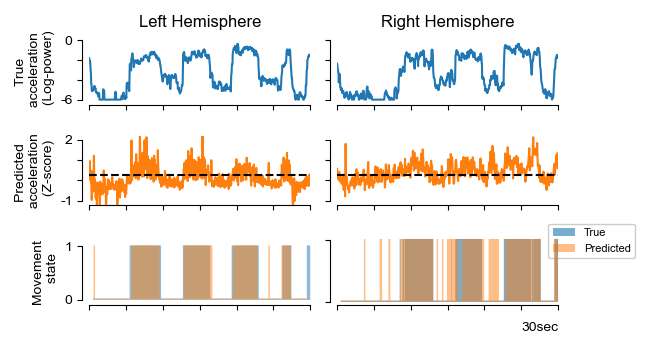

In [25]:
plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Transform the LD output back into original acceleration units and compute R2,r
_, left_accel, left_accel_ts, _ = left_mdl.preprocess(refit_scaler=False)
left_accel = np.squeeze(
              left_mdl.accel_scaler.inverse_transform(left_accel.reshape(-1,1)))
left_accel_pred = xform_ld_output(left_output.reshape(-1,1), left_mdl)
left_threshold_xformed = xform_ld_output([[left_mdl.threshold]], left_mdl)

_, right_accel, right_accel_ts, _ = right_mdl.preprocess(refit_scaler=False)
right_accel = np.squeeze(
            right_mdl.accel_scaler.inverse_transform(right_accel.reshape(-1,1)))
right_accel_pred = xform_ld_output(right_output.reshape(-1,1), right_mdl)
right_threshold_xformed = xform_ld_output([[right_mdl.threshold]], right_mdl)

# Plot example segment
fig, ax = plt.subplots(3,2, figsize=(6.5,3.5), sharex=True)

t0 = left_state_ts[0]
left_idx = (left_state_ts-t0 > 1743) & (left_state_ts-t0 < 1900)
right_idx = (right_state_ts-t0 > 1743) & (right_state_ts-t0 < 1900)
left_idx2 = (left_state_ts-t0 > 1900) & (left_state_ts-t0 < 1920)
right_idx2 = (right_state_ts-t0 > 1900) & (right_state_ts-t0 < 1920)

ax[0,0].set_title('Left Hemisphere')
ax[0,0].plot(left_mdl.accel_ts[0]-t0, np.clip(left_mdl.accel[0], -6, 0))
ax[0,0].set_ylabel('True \n acceleration \n (Log-power)')
ax[1,0].plot(left_output_ts-t0, left_output-0.4838079459698036, 
             color='tab:orange')
ax[1,0].set_ylabel('Predicted \n acceleration \n (Z-score)')
ax[1,0].axhline(left_mdl.threshold-0.4838079459698036, 
                color='k', linestyle='--')

ax[2,0].fill_between(left_state_ts[left_idx]-t0, left_state_true[left_idx]+0.02, 
                     alpha=0.5, step='mid', label='True', clip_on=False, zorder=10)
ax[2,0].fill_between(left_state_ts[left_idx]-t0, left_state_pred[left_idx]+0.02, 
                     alpha=0.5, step='mid', label='Predicted', clip_on=False, zorder=10)
ax[2,0].fill_between(left_state_ts[left_idx2]-t0, left_state_true[left_idx2]+0.02, 
                     alpha=0.5, step='mid', label='True', clip_on=False, zorder=10, facecolor='tab:blue')
ax[2,0].fill_between(left_state_ts[left_idx2]-t0, left_state_pred[left_idx2]+0.02, 
                     alpha=0.5, step='mid', label='Predicted', clip_on=False, zorder=10, facecolor='tab:orange')
ax[2,0].set_ylabel('Movement \n state')

ax[0,1].set_title('Right Hemisphere')
ax[0,1].plot(right_mdl.accel_ts[0]-t0, np.clip(right_mdl.accel[0], -6, 0))
ax[1,1].plot(right_output_ts-t0, right_output-0.9764343875489059, 
             color='tab:orange')
ax[1,1].axhline(right_mdl.threshold-0.9764343875489059, 
                color='k', linestyle='--')

ax[2,1].fill_between(right_state_ts[right_idx]-t0, right_state_true[right_idx]+0.02, 
                     alpha=0.6, facecolor='tab:blue', step='mid', label='True', 
                     clip_on=False, zorder=100)
ax[2,1].fill_between(right_state_ts[right_idx]-t0, right_state_pred[right_idx]+0.02, 
                     alpha=0.5, facecolor='tab:orange', step='mid', 
                     label='Predicted', clip_on=False, zorder=100)
ax[2,1].fill_between(right_state_ts[right_idx2]-t0, right_state_true[right_idx2]+0.02, 
                     alpha=0.6, facecolor='tab:blue', step='mid', 
                     clip_on=False, zorder=10)
ax[2,1].fill_between(right_state_ts[right_idx2]-t0, right_state_pred[right_idx2]+0.02, 
                     alpha=0.5, facecolor='tab:orange', step='mid', 
                     clip_on=False, zorder=10)

ax[0,0].set_ylim([-6.5,0.5])
ax[0,0].set_yticks(np.arange(-6,1,2))
ax[0,0].set_yticklabels([-6, '', '', 0])
ax[0,1].set_ylim([-6.5,0.5])
ax[0,1].set_yticks(np.arange(-6,1,2))
ax[1,0].set_yticklabels([-1, '', '', 2])
ax[2,0].set_ylim([-0.1,1.2])
ax[2,0].set_yticks([0,1])
for i in range(3):
    ax[i,1].set_yticklabels([])
        
ax[0,0].spines.left.set_bounds(-6, 0)
ax[0,0].spines.left.set_position(('outward', 5))
ax[0,0].spines.right.set_visible(False)
ax[0,0].spines.top.set_visible(False)
ax[0,0].yaxis.set_ticks_position('left')
ax[0,0].xaxis.set_ticks_position('bottom')

ax[0,1].spines.left.set_bounds(-6, 0)
ax[0,1].spines.left.set_position(('outward', 5))
ax[0,1].spines.right.set_visible(False)
ax[0,1].spines.top.set_visible(False)
ax[0,1].yaxis.set_ticks_position('left')
ax[0,1].xaxis.set_ticks_position('bottom')

ax[1,0].set_ylim([-1.2,2.2])
ax[1,0].set_yticks(np.linspace(-1,2,4))
ax[1,1].set_ylim([-1.2,2.2])
ax[1,1].set_yticks(np.linspace(-1,2,4))

ax[1,0].spines.left.set_bounds(-1, 2)
ax[1,0].spines.left.set_position(('outward', 5))
ax[1,0].spines.right.set_visible(False)
ax[1,0].spines.top.set_visible(False)
ax[1,0].yaxis.set_ticks_position('left')
ax[1,0].xaxis.set_ticks_position('bottom')

ax[2,0].spines.left.set_bounds(0, 1)
ax[2,0].spines.left.set_position(('outward', 5))
ax[2,0].spines.right.set_visible(False)
ax[2,0].spines.top.set_visible(False)
ax[2,0].yaxis.set_ticks_position('left')
ax[2,0].xaxis.set_ticks_position('bottom')

ax[1,1].spines.left.set_bounds(-1, 2)
ax[1,1].spines.left.set_position(('outward', 5))
ax[1,1].spines.right.set_visible(False)
ax[1,1].spines.top.set_visible(False)
ax[1,1].yaxis.set_ticks_position('left')
ax[1,1].xaxis.set_ticks_position('bottom')

ax[2,1].spines.left.set_bounds(0, 1)
ax[2,1].spines.left.set_position(('outward', 5))
ax[2,1].spines.right.set_visible(False)
ax[2,1].spines.top.set_visible(False)
ax[2,1].yaxis.set_ticks_position('left')
ax[2,1].xaxis.set_ticks_position('bottom')

ax[0,1].set_xlim([1740,1920])
ax[0,0].set_xticks(np.arange(1740,1921,30))
ax[2,1].set_xlabel('30sec');
for i in range(2):
    for j in range(2):
        ax[i,j].set_xticklabels([])

ax[2,1].legend(loc='lower left', bbox_to_anchor=(0.93, 0.6), 
               prop={'size': 8}, facecolor='white', framealpha=1)

plt.tight_layout()
ax[2,1].xaxis.set_label_coords(0.92, -0.25)

plt.tight_layout()
# plt.savefig('offline_example.svg', format='svg', rasterized=True)

#### Figure 4b: Confusion matrices

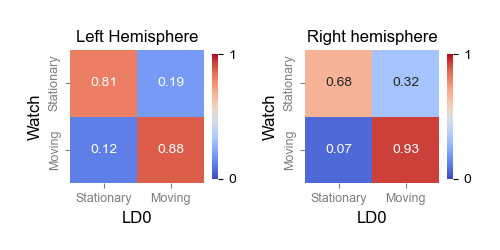

In [26]:
fig, ax = plt.subplots(1,2, figsize=(5,2.5))

sns.heatmap(conf_mat_left, ax=ax[0], annot=True, vmin=0, vmax=1, 
            cmap='coolwarm', xticklabels=['Stationary', 'Moving'], 
            yticklabels=['Stationary', 'Moving'], 
            cbar_kws={"shrink": .70, "ticks": [0,1]})
ax[0].set_title('Left Hemisphere')
ax[0].set_aspect('equal')

sns.heatmap(conf_mat_right, ax=ax[1], annot=True, vmin=0, vmax=1, 
            cmap='coolwarm', xticklabels=['Stationary', 'Moving'], 
            yticklabels=['Stationary', 'Moving'], 
            cbar_kws={"shrink": .70, "ticks": [0,1]})
ax[1].set_title('Right hemisphere')
ax[1].set_aspect('equal')
# plt.colorbar(fraction=0.046, pad=0.04)

for i in range(2):
    ax[i].set_xlabel('LD0', fontsize=12)
    ax[i].set_ylabel('Watch', fontsize=12)
    ax[i].tick_params(axis='both', colors='tab:grey', labelsize=9)

plt.tight_layout(pad=2)
# plt.savefig('offline_conf_mat.svg', format='svg')

#### Figure 4d: Distributions of LD output and stimulation in different movement states

In [27]:
# Compute stimulation estimates
left_stim, left_stim_ts = rcs.state_to_stim(left_state_pred, left_state_ts, 
                                          target_amp=[1.6, 2.2, 2.2, 0,0,0,0,0], 
                                          rise_time=1.6, fall_time=1.6)
left_stim = np.interp(left_state_ts, left_stim_ts, left_stim)
right_stim, right_stim_ts = rcs.state_to_stim(right_state_pred, right_state_ts, 
                                          target_amp=[1.6, 2.2, 2.2, 0,0,0,0,0], 
                                          rise_time=1.6, fall_time=1.6)
right_stim = np.interp(right_state_ts, right_stim_ts, right_stim)

# filter the arm movement segments
left_state_true_seg = left_state_true[left_mask]
left_state_pred_seg = left_state_pred[left_mask]
left_output_seg = left_output[left_mask]
left_stim_seg = left_stim[left_mask]
left_accel_seg = np.interp(left_state_ts, left_accel_ts, left_accel)
left_accel_seg = left_accel_seg[left_mask]

right_state_true_seg = right_state_true[right_mask]
right_state_pred_seg = right_state_pred[right_mask]
right_output_seg = right_output[right_mask]
right_stim_seg = right_stim[right_mask]
right_accel_seg = np.interp(right_state_ts, right_accel_ts, right_accel)
right_accel_seg = right_accel_seg[right_mask]

# separate data by state
left_output_x_state = [np.squeeze(left_output_seg)[left_state_true_seg==i] 
                       for i in range(2)]
right_output_x_state = [np.squeeze(right_output_seg)[right_state_true_seg==i] 
                        for i in range(2)]

left_stim_x_state = [np.clip(left_stim_seg, 1.6, 2.2)[left_state_true_seg==i] 
                       for i in range(2)]
right_stim_x_state = [np.clip(right_stim_seg, 1.6, 2.2)[right_state_true_seg==i] 
                        for i in range(2)]

num_samples_left = [len(left_stim_x_state[0]), len(left_stim_x_state[1])]
num_samples_right = [len(right_stim_x_state[0]), len(right_stim_x_state[1])]

left_low_stim = [np.sum(left_stim_x_state[0]==1.6)/num_samples_left[0], 
                 np.sum(left_stim_x_state[1]==1.6)/num_samples_left[1]]
left_high_stim = [np.sum(left_stim_x_state[0]==2.2)/num_samples_left[0], 
                  np.sum(left_stim_x_state[1]==2.2)/num_samples_left[1]]
left_tran_stim = [1 - left_low_stim[0] - left_high_stim[0], 
                  1 - left_low_stim[1] - left_high_stim[1]]
right_low_stim = [np.sum(right_stim_x_state[0]==1.6)/num_samples_right[0], 
                  np.sum(right_stim_x_state[1]==1.6)/num_samples_right[1]]
right_high_stim = [np.sum(right_stim_x_state[0]==2.2)/num_samples_right[0], 
                   np.sum(right_stim_x_state[1]==2.2)/num_samples_right[1]]
right_tran_stim = [1 - right_low_stim[0] - right_high_stim[0], 
                   1 - right_low_stim[1] - right_high_stim[1]]

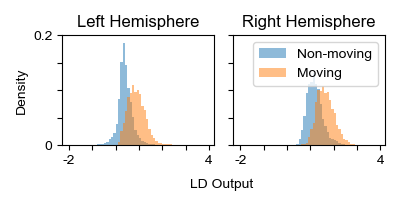

In [28]:
fig, ax = plt.subplots(1,2, figsize=(4,2), sharex='row', sharey='row')
ax[0].set_title('Left Hemisphere')
ax[1].set_title('Right Hemisphere')

ax[0].hist(left_output_x_state[0], np.arange(-2,4,0.1), alpha=0.5, 
             weights=np.ones(num_samples_left[0])/num_samples_left[0])
ax[0].hist(left_output_x_state[1], np.arange(-2,4,0.1), alpha=0.5, 
             weights=np.ones(num_samples_left[1])/num_samples_left[1])
ax[1].hist(right_output_x_state[0], np.arange(-2,4,0.1), alpha=0.5, 
             weights=np.ones(num_samples_right[0])/num_samples_right[0], 
             label='Non-moving')
ax[1].hist(right_output_x_state[1], np.arange(-2,4,0.1), alpha=0.5, 
             weights=np.ones(num_samples_right[1])/num_samples_right[1], 
             label='Moving')
ax[1].legend()

ax[0].set_ylabel('Density')
ax[0].set_xlabel('LD Output')

ax[0].set_yticks(np.arange(0,0.201,0.05))
ax[0].set_yticklabels(['0', '', '', '', '0.2'])
ax[1].set_yticks(np.arange(0,0.201,0.05))
ax[1].set_yticklabels(['0', '', '', '', '0.2'])
ax[0].set_xticks(np.arange(-2,4.01,1))
ax[0].set_xticklabels(['-2'] + ['']*5 + ['4'])

plt.tight_layout()
ax[0].xaxis.set_label_coords(1.05, -0.3)

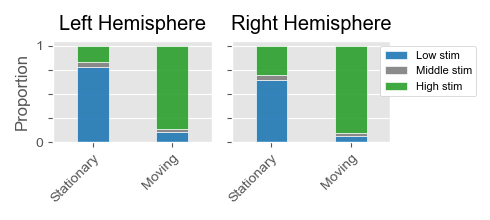

In [29]:
plt.style.use('ggplot')
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

fig, ax = plt.subplots(1,2, figsize=(4.9,2.2), sharex='row', sharey='row')

ax[0].set_title('Left Hemisphere', pad=8.0)
ax[1].set_title('Right Hemisphere', pad=8.0)

ax[0].bar([0,1], left_low_stim, color='tab:blue', edgecolor='white', alpha=0.9,
          width=0.4)
ax[0].bar([0,1], left_tran_stim, bottom=left_low_stim, color='tab:grey', 
          edgecolor='white', alpha=0.9, width=0.4)
ax[0].bar([0,1], left_high_stim, 
          bottom=[i+j for i,j in zip(left_low_stim, left_tran_stim)], 
          color='tab:green', edgecolor='white', alpha=0.9, width=0.4)

ax[1].bar([0,1], right_low_stim, color='tab:blue', edgecolor='white', 
          alpha=0.9, width=0.4, label='Low stim')
ax[1].bar([0,1], right_tran_stim, bottom=right_low_stim, color='tab:grey', 
          edgecolor='white', alpha=0.9, width=0.4, label='Middle stim')
ax[1].bar([0,1], right_high_stim, 
          bottom=[i+j for i,j in zip(right_low_stim, right_tran_stim)], 
          color='tab:green', edgecolor='white', alpha=0.9, width=0.4, 
          label='High stim')

ax[0].set_ylabel('Proportion')
ax[0].set_yticks(np.arange(0,1.1,0.25))
ax[0].set_yticklabels(['0', '', '', '', '1'])
ax[1].set_yticks(np.arange(0,1.1,0.25))
ax[1].set_yticklabels(['0', '', '', '', '1'])
ax[0].set_xticks([0,1])
ax[0].set_xlim([-0.5, 1.5])
ax[0].set_xticklabels(['Stationary', 'Moving'], rotation=45, ha='right', 
                      rotation_mode='anchor')
ax[1].set_xticklabels(['Stationary', 'Moving'], rotation=45, ha='right', 
                      rotation_mode='anchor')
leg = ax[1].legend(loc='lower left', bbox_to_anchor=(0.9, 0.4), 
                   prop={'size': 8}, facecolor='white', framealpha=1)

ax[0].grid(axis='x')
ax[1].grid(axis='x')
plt.tight_layout()
# plt.savefig('predicted_stim_distributions.svg', format='svg')

#### Figure 4c: Distributions of accelerometry in different movement states

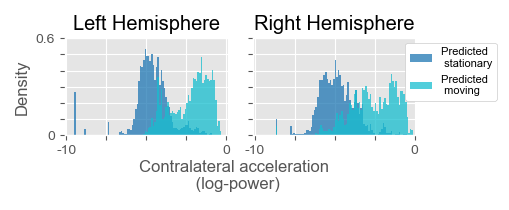

In [30]:
left_accel_x_state = [np.squeeze(left_accel_seg)[left_state_pred_seg==i] 
                       for i in range(2)]
right_accel_x_state = [np.squeeze(right_accel_seg)[right_state_pred_seg==i] 
                        for i in range(2)]

fig, ax = plt.subplots(1,2, figsize=(5.1,2.1), sharex='row', sharey='row')
ax[0].set_title('Left Hemisphere')
num_samples_left = [len(left_accel_x_state[0]), len(left_accel_x_state[1])]
ax[1].set_title('Right Hemisphere')
num_samples_right = [len(right_accel_x_state[0]), len(right_accel_x_state[1])]

ax[0].hist(left_accel_x_state[0], np.arange(-10,0,0.1), alpha=0.75, 
           density=True, color='tab:blue', label='Predicted \n stationary')
ax[0].hist(left_accel_x_state[1], np.arange(-10,0,0.1), alpha=0.75, 
           density=True, color='tab:cyan', label='Predicted \n moving')
ax[1].hist(right_accel_x_state[0], np.arange(-10,0,0.1), alpha=0.75, 
           density=True, color='tab:blue', label='Predicted \n stationary')
ax[1].hist(right_accel_x_state[1], np.arange(-10,0,0.1), alpha=0.75, 
           density=True, color='tab:cyan', label='Predicted \n moving')
leg = ax[1].legend(loc='lower left', bbox_to_anchor=(0.9, 0.3), 
                   prop={'size': 8}, facecolor='white', framealpha=1)

ax[0].set_ylabel('Density')
ax[0].set_xlabel('Contralateral acceleration \n (log-power)')


ax[0].set_ylim([0,0.6])
ax[0].set_yticks(np.arange(0,0.61,0.1))
ax[1].set_yticks(np.arange(0,0.61,0.1))
ax[0].set_yticklabels(['0'] + ['']*5 + ['0.6'])
ax[0].set_xlim([-10.1, 0.1])
ax[0].set_xticks(np.arange(-10,0.1,2.5))
ax[0].set_xticklabels(['-10'] + ['']*3 + ['0'])

plt.tight_layout()
ax[0].xaxis.set_label_coords(1.05, -0.25)
# plt.savefig('accel_distributions_by_prediction.svg', format='svg')